# Pipeline processing using rsexecute workflows.

This notebook demonstrates the continuum imaging and ICAL pipelines. These are based on RASCIL functions wrapped
     up as SDP workflows using the rsexecute class.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = '/tmp/'

from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt

from rascil.data_models.polarisation import PolarisationFrame

from rascil.processing_components import show_image, export_image_to_fits, qa_image, \
    create_low_test_image_from_gleam, create_image_from_visibility, advise_wide_field,\
    convert_blockvisibility_to_visibility

from rascil.workflows import invert_list_rsexecute_workflow, predict_list_rsexecute_workflow, \
    deconvolve_list_rsexecute_workflow, simulate_list_rsexecute_workflow, \
    corrupt_list_rsexecute_workflow, continuum_imaging_list_rsexecute_workflow

from rascil.workflows.rsexecute.execution_support.rsexecute import rsexecute

import pprint

pp = pprint.PrettyPrinter()

import logging

log = logging.getLogger()
logging.info("Starting imaging-pipeline")
mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 


Set up rsexecute to use dask. If we are running in docker then the scheduler may be available by name.
Otherwise we just create a LocalCluster.

In [2]:
from dask.distributed import Client, LocalCluster
try:
    client = Client('scheduler:8786', timeout=10)
except OSError:
    client =Client(LocalCluster())
print(client)

rsexecute.set_client(client=client)

<Client: 'tcp://127.0.0.1:64363' processes=4 threads=16, memory=68.72 GB>


In [3]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'Greys'

We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations 
used. 

After creating the graph, we can add a conversion step.

Finally we compute the value of the graph, a list of visibility objects. These can then be scattered to the
cluster of workers.

In [4]:
nfreqwin=7
ntimes=5
rmax=300.0
frequency=numpy.linspace(1e8,1.2e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

bvis_list=simulate_list_rsexecute_workflow('LOWBD2',
                                         frequency=frequency, 
                                         channel_bandwidth=channel_bandwidth,
                                         times=times,
                                         phasecentre=phasecentre,
                                         order='frequency',
                                        rmax=rmax, format='blockvis')
vis_list = [rsexecute.execute(convert_blockvisibility_to_visibility)(bv) for bv in bvis_list]

print('%d elements in vis_list' % len(vis_list))
log.info('About to make visibility')
vis_list = rsexecute.compute(vis_list, sync=True)

7 elements in vis_list


Find the recommended values for the wide field imaging.

In [5]:
wprojection_planes=1
advice_low=advise_wide_field(vis_list[0], guard_band_image=8.0, delA=0.02,
                             wprojection_planes=wprojection_planes)

advice_high=advise_wide_field(vis_list[-1], guard_band_image=8.0, delA=0.02,
                              wprojection_planes=wprojection_planes)

vis_slices = advice_low['vis_slices']
npixel=advice_high['npixels2']
cellsize=min(advice_low['cellsize'], advice_high['cellsize'])

Now make a graph to fill with a model drawn from GLEAM. There will be one model image
per frequency.

In [6]:
gleam_model = [rsexecute.execute(create_low_test_image_from_gleam)(npixel=npixel,
                                                               frequency=[frequency[f]],
                                                               channel_bandwidth=[channel_bandwidth[f]],
                                                               cellsize=cellsize,
                                                               phasecentre=phasecentre,
                                                               polarisation_frame=PolarisationFrame("stokesI"),
                                                               flux_limit=1.0,
                                                               applybeam=True)
                     for f, freq in enumerate(frequency)]
log.info('About to make GLEAM model')
gleam_model = rsexecute.compute(gleam_model, sync=True)
future_gleam_model = rsexecute.scatter(gleam_model)

Now we can fill in the visibility values from the models, using a workflow.

In [7]:
log.info('About to run predict to get predicted visibility')
future_vis_graph = rsexecute.scatter(vis_list)
predicted_vislist = predict_list_rsexecute_workflow(future_vis_graph, gleam_model,  
                                                context='wstack', vis_slices=vis_slices)
predicted_vislist = rsexecute.compute(predicted_vislist, sync=True)
corrupted_vislist = corrupt_list_rsexecute_workflow(predicted_vislist, phase_error=1.0)
log.info('About to run corrupt to get corrupted visibility')
corrupted_vislist =  rsexecute.compute(corrupted_vislist, sync=True)
future_predicted_vislist=rsexecute.scatter(predicted_vislist)

/Users/timcornwell/opt/anaconda3/envs/rascil_env/lib/python3.7/site-packages/distributed/worker.py:3349: UserWarning: Large object of size 2.10 MB detected in task graph: 
  ('getitem-9d3cd70638bd61be2e56b5baaa7d932c', <rasc ... -e59afae69090')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


Get the LSM. This is blank.

In [8]:
model_list = [rsexecute.execute(create_image_from_visibility)(vis_list[f],
                                                     npixel=npixel,
                                                     frequency=[frequency[f]],
                                                     channel_bandwidth=[channel_bandwidth[f]],
                                                     cellsize=cellsize,
                                                     phasecentre=phasecentre,
                                                     polarisation_frame=PolarisationFrame("stokesI"))
               for f, freq in enumerate(frequency)]

Make the graphs to calculate the dirty image and psf, but don't compute the values yet.

In [9]:

dirty_list = invert_list_rsexecute_workflow(future_predicted_vislist, model_list, 
                                  context='wstack',
                                  vis_slices=vis_slices, dopsf=False)
psf_list = invert_list_rsexecute_workflow(future_predicted_vislist, model_list, 
                                context='wstack',
                                vis_slices=vis_slices, dopsf=True)

Compute the graphs to make the dirty image and PSF

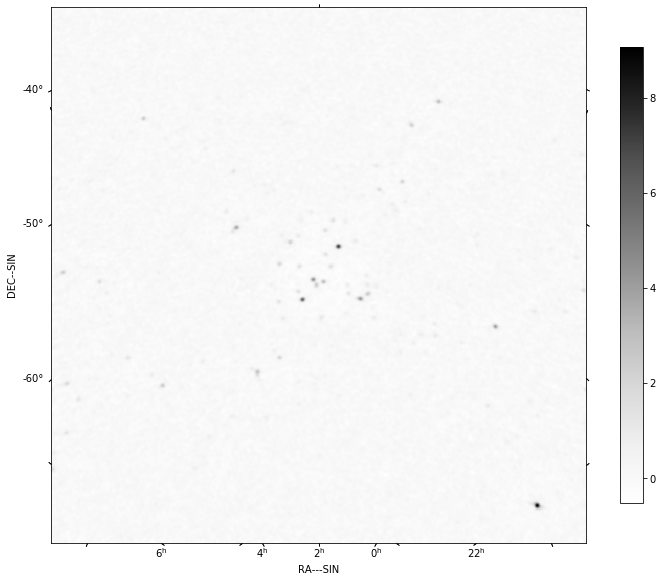

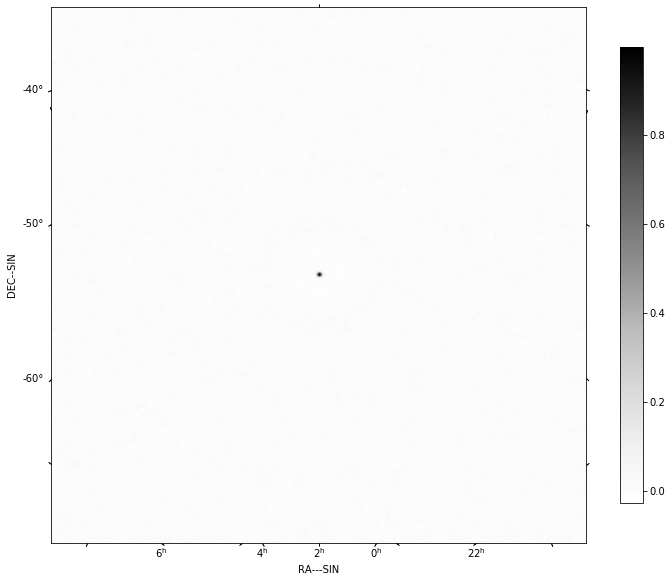

In [10]:
log.info('About to run invert to get dirty image')
dirty_list =  rsexecute.compute(dirty_list, sync=True)
dirty = dirty_list[0][0]
show_image(dirty, cm='Greys')
plt.show()

log.info('About to run invert to get PSF')
psf_list =  rsexecute.compute(psf_list, sync=True)
psf = psf_list[0][0]
show_image(psf, cm='Greys')
plt.show()

Now deconvolve using msclean

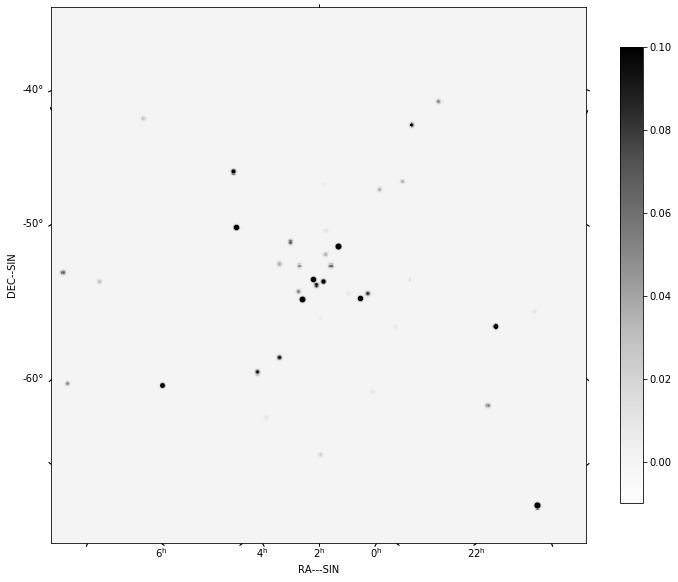

In [11]:
log.info('About to run deconvolve')

deconvolve_list = \
    deconvolve_list_rsexecute_workflow(dirty_list, psf_list, model_imagelist=model_list, 
                            deconvolve_facets=8, deconvolve_overlap=16, deconvolve_taper='tukey',
                            scales=[0, 3, 10],
                            algorithm='msclean', niter=1000, 
                            fractional_threshold=0.1,
                            threshold=0.1, gain=0.1, psf_support=64)
    
centre=nfreqwin // 2

deconvolved = rsexecute.compute(deconvolve_list, sync=True)
show_image(deconvolved[centre], cm='Greys', vmax=0.1, vmin=-0.01)
plt.show()

Finally we can try the continuum imaging pipeline. First construct the graph.

In [12]:
continuum_imaging_list = \
    continuum_imaging_list_rsexecute_workflow(future_predicted_vislist, 
                                            model_imagelist=model_list, 
                                            context='wstack', vis_slices=vis_slices, 
                                            scales=[0, 3, 10], algorithm='mmclean', 
                                            nmoment=2, niter=1000, 
                                            fractional_threshold=0.3,
                                            threshold=0.1, nmajor=5, gain=0.25,
                                            deconvolve_facets = 8, deconvolve_overlap=16, 
                                            deconvolve_taper='tukey', psf_support=64)


Now execute the graph

In [ ]:
log.info('About to run continuum imaging')

centre=nfreqwin // 2
continuum_imaging_list=rsexecute.compute(continuum_imaging_list, sync=True)
deconvolved = continuum_imaging_list[0][centre]
residual = continuum_imaging_list[1][centre]
restored = continuum_imaging_list[2][centre]

f=show_image(deconvolved, title='Clean image - no selfcal', cm='Greys', 
             vmax=0.1, vmin=-0.01)
print(qa_image(deconvolved, context='Clean image - no selfcal'))

plt.show()

f=show_image(restored, title='Restored clean image - no selfcal', 
             cm='Greys', vmax=1.0, vmin=-0.1)
print(qa_image(restored, context='Restored clean image - no selfcal'))
plt.show()
export_image_to_fits(restored, '%s/imaging-dask_continuum_imaging_restored.fits' 
                     %(results_dir))

f=show_image(residual[0], title='Residual clean image - no selfcal', cm='Greys')
print(qa_image(residual[0], context='Residual clean image - no selfcal'))
plt.show()
export_image_to_fits(residual[0], '%s/imaging-dask_continuum_imaging_residual.fits' 
                     %(results_dir))